In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [30]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)'],
      dtype='object')

In [31]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 20 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Accept_One             2227 non-null int64
Cust_Accept (%)        2227 non-null float64
dtypes: float64(5), i

*Preprocessing for Customer Segmentation / Classification / Regression Below*

In [32]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])

Text(0.5, 1.0, 'Elbow Plot')

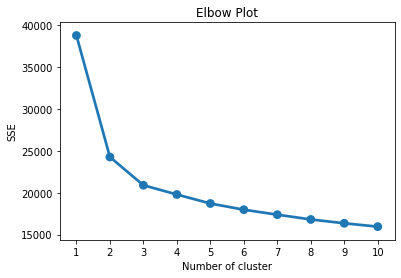

In [33]:
from sklearn.cluster import KMeans
import seaborn as sns

X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')

In [34]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml)
labels = kmeans.labels_
marketing['Cluster'] = labels
print('Cluster Counts')
print(marketing['Cluster'].value_counts())
education = marketing.groupby(['Cluster', 'Education'])['Education'].count()
print('\nPercentage of Cluster Totals by Education')
print(round((education / education.groupby(level=0).sum()) * 100))
relationship = marketing.groupby(['Cluster', 'Relationship_Status'])['Education'].count()
print('\nPercentage of Cluster Totals by Relationship Status')
print(round((relationship / relationship.groupby(level=0).sum()) * 100))
print('\nNumerical Data - Grouped by Cluster (Means)')
marketing.groupby('Cluster').mean()

Cluster Counts
1    853
0    721
2    653
Name: Cluster, dtype: int64

Percentage of Cluster Totals by Education
Cluster  Education 
0        2n Cycle       9.0
         Basic          0.0
         Graduation    55.0
         Master        15.0
         PhD           21.0
1        2n Cycle      11.0
         Basic          6.0
         Graduation    48.0
         Master        16.0
         PhD           19.0
2        2n Cycle       6.0
         Graduation    48.0
         Master        20.0
         PhD           26.0
Name: Education, dtype: float64

Percentage of Cluster Totals by Relationship Status
Cluster  Relationship_Status
0        Divorced               10.0
         In-Relationship        25.0
         Married                38.0
         Single                 23.0
         Widow                   5.0
1        Divorced                9.0
         In-Relationship        25.0
         Married                39.0
         Single                 23.0
         Widow              

,Age,Income,Children,Wine ($),Fruit ($),Meat ($),Fish ($),Sweets ($),Gold_Products ($),Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Days_Enrolled,Avg_Purch_Freq,Avg_Spend ($),Accept_One,Cust_Accept (%)
Cluster,,,,,,,,,,,,,,,,,,
0,45.950069,72680.043829,0.316227,588.891817,64.016644,395.135922,92.621359,65.061026,76.689320,1.445215,5.453537,5.485437,8.470180,473.564494,23.915394,63.543838,0.427184,13.869626
1,41.783118,32789.066114,1.245018,24.318875,3.720985,18.848769,5.234467,4.490035,12.906213,1.841735,1.839390,0.424385,2.909730,481.307151,77.834633,9.415135,0.132474,2.735444
2,48.434916,53932.429442,1.269525,356.552833,14.297090,107.611026,19.229709,14.952527,48.857580,3.943338,5.543645,2.491577,6.641654,473.707504,27.390648,28.667020,0.280245,6.533946


We see that one particular group had 43% of customers accept the offer at least once while also containing an average customer acceptance percentage of 14%. 

The next most promising group had 28% of customers accept the offer at least once while also containing an average customer acceptance percentage of 7%.

Least promising group had 13% of customers accept the offer at least once while also containing an average customer acceptance percentage of 3%. 

**Classification - 1)Predict Acceptance of one offer  2) Predict amount of times out of six (probability)**

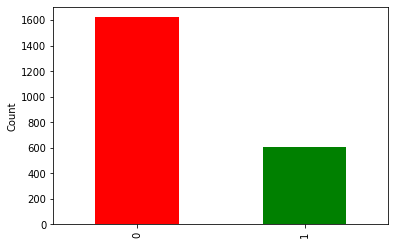

0    1623
1     604
Name: Accept_One, dtype: int64


In [35]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

In [36]:
### RandomForest - no imbalancing techniques ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)


 *Most Important Education Category*
                 cols       imp
 Education_Graduation  0.006956

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.007588

 *Most Important Purchases Category*
            cols       imp
 Store_Purchases  0.053365

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.179372


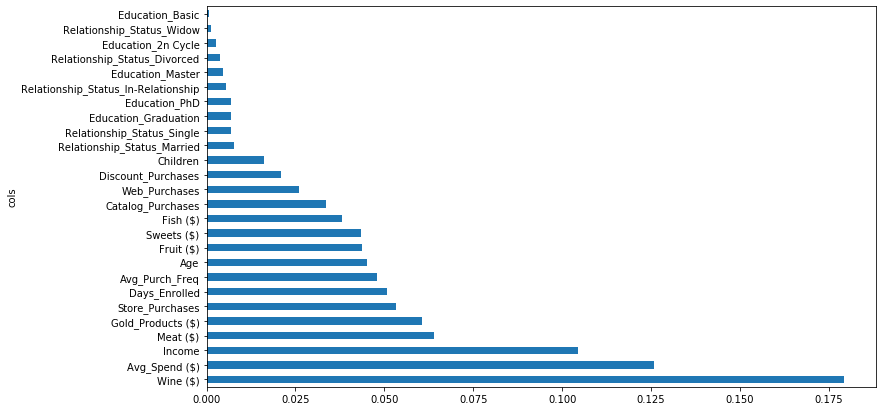


OOB Score:  0.8077844311377246

Best Params: {'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}

Testing Accuracy: 0.8043087971274686
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       399
           1       0.74      0.48      0.58       158

    accuracy                           0.80       557
   macro avg       0.78      0.71      0.73       557
weighted avg       0.80      0.80      0.79       557

[[372  27]
 [ 82  76]]


In [37]:
### Analyzing Performance & Feature Importance Towards Accept_One ###
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(best_clf, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

In [38]:
### Gradient Boosting - no imbalancing techniques ###
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.81      0.91      0.85       399
           1       0.66      0.45      0.53       158

    accuracy                           0.78       557
   macro avg       0.73      0.68      0.69       557
weighted avg       0.76      0.78      0.76       557

[[362  37]
 [ 87  71]]


**----Undersampling----**

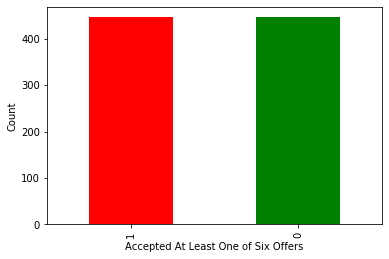

1    446
0    446
dtype: int64


In [39]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())



 *Most Important Education Category*
             cols      imp
 Education_Master  0.00744

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.008993

 *Most Important Purchases Category*
            cols       imp
 Store_Purchases  0.052627

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.147351


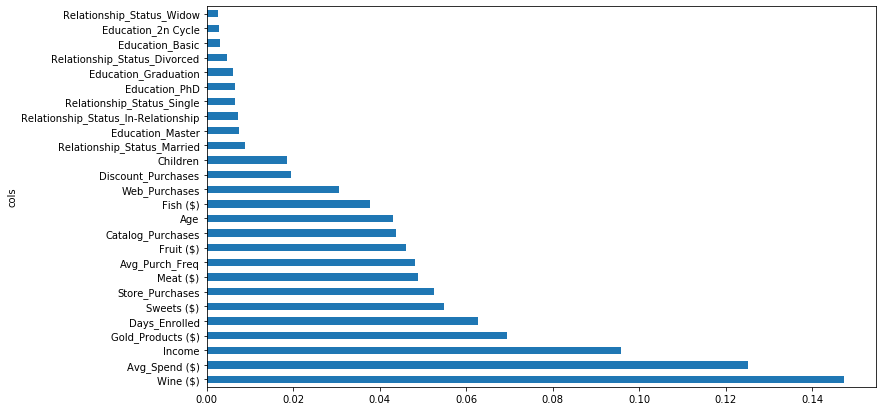


OOB Score:  0.7544843049327354

Best Params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}

Testing Accuracy: 0.7522441651705566
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       399
           1       0.55      0.75      0.63       158

    accuracy                           0.75       557
   macro avg       0.71      0.75      0.72       557
weighted avg       0.79      0.75      0.76       557

[[301  98]
 [ 40 118]]


In [40]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

In [41]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier()
xgb.fit(X_resampled, y_resampled)
y_pred_test = xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       399
           1       0.52      0.69      0.59       158

    accuracy                           0.73       557
   macro avg       0.69      0.72      0.70       557
weighted avg       0.76      0.73      0.74       557

[[298 101]
 [ 49 109]]


**----Oversampling----**

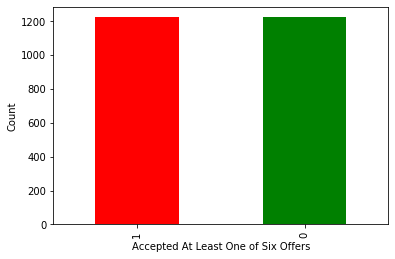

1    1224
0    1224
dtype: int64


In [42]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())


 *Most Important Education Category*
                 cols       imp
 Education_Graduation  0.012352

 *Most Important Relationship_Status Category*
                       cols       imp
 Relationship_Status_Single  0.018497

 *Most Important Purchases Category*
              cols       imp
 Catalog_Purchases  0.077051

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.102071


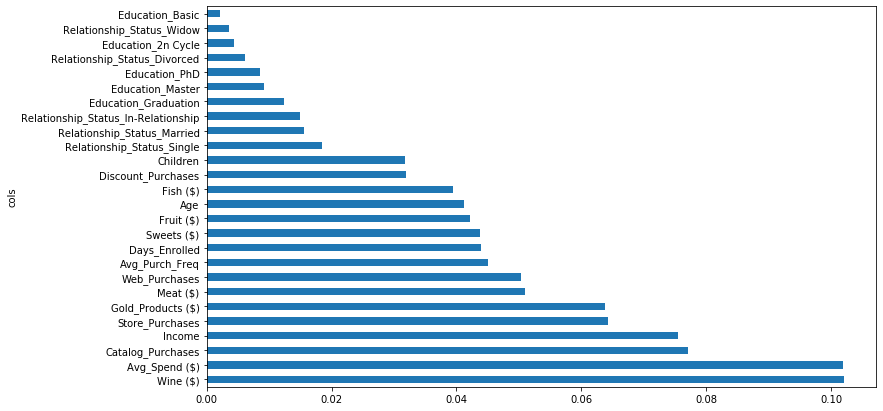


OOB Score:  0.891748366013072

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 600}

Testing Accuracy: 0.8043087971274686
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       399
           1       0.68      0.59      0.63       158

    accuracy                           0.80       557
   macro avg       0.76      0.74      0.75       557
weighted avg       0.80      0.80      0.80       557

[[355  44]
 [ 65  93]]


In [43]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

In [44]:
### Gradient Boost Classifier Using Oversampling ###

xgb = XGBClassifier()
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       399
           1       0.61      0.51      0.56       158

    accuracy                           0.77       557
   macro avg       0.71      0.69      0.70       557
weighted avg       0.76      0.77      0.76       557

[[347  52]
 [ 77  81]]


**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

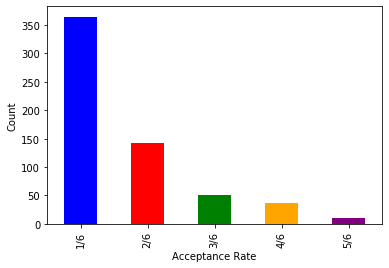

Accept_Rate
1/6    365
2/6    142
3/6     51
4/6     36
5/6     10
Name: Accept_Rate, dtype: int64


In [45]:
### Sclicing to only included customers who accepted at least one offer ###
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)
### Adding Accept_Rate Labels ###
marketing_accept['Accept_Rate'] = ''
for idx, row in marketing_accept.iterrows():
    if row['Cust_Accept (%)'] == ((1/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '1/6'
    elif row['Cust_Accept (%)'] == ((2/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '2/6'
    elif row['Cust_Accept (%)'] == ((3/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '3/6'
    elif row['Cust_Accept (%)'] == ((4/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '4/6'
    elif row['Cust_Accept (%)'] == ((5/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '5/6'

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count())

In [46]:
### Numerically Encode Accept_Rate ###
for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '1/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '2/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '3/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    elif row['Accept_Rate'] == '4/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 4
    elif row['Accept_Rate'] == '5/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 5
        
marketing_ml_accept = marketing_accept.drop(['Cluster', 'Accept_Rate', 'Accept_One', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')
print(len(ml_accept))

604


In [47]:
print(marketing_accept['Accept_Rate'].value_counts())
print(ml_accept.info())


1    365
2    142
3     51
4     36
5     10
Name: Accept_Rate, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 26 columns):
0                                      604 non-null float64
1                                      604 non-null float64
2                                      604 non-null float64
3                                      604 non-null float64
4                                      604 non-null float64
5                                      604 non-null float64
6                                      604 non-null float64
7                                      604 non-null float64
8                                      604 non-null float64
9                                      604 non-null float64
10                                     604 non-null float64
11                                     604 non-null float64
12                                     604 non-null float64
13                                    

In [48]:
### Classifier for Accept_Rate ###
X = ml_accept.values
y = marketing_accept['Accept_Rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
# params = {'C' : [.001, .01, 0.1, 1, 10, 100]}
# SVM = svm.SVC(kernel='rbf')
# grid_search = GridSearchCV(SVM, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# best_class_accept = grid_search.best_estimator_
# y_pred = best_class_accept.predict(X_test)
# print(best_class_accept.score(X_test, y_test))
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

In [49]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.69      0.80      0.74        91
           2       0.33      0.24      0.28        34
           3       0.29      0.31      0.30        13
           4       0.50      0.30      0.37        10
           5       1.00      0.33      0.50         3

    accuracy                           0.59       151
   macro avg       0.56      0.40      0.44       151
weighted avg       0.57      0.59      0.57       151

[[73 12  4  2  0]
 [23  8  2  1  0]
 [ 7  2  4  0  0]
 [ 3  1  3  3  0]
 [ 0  1  1  0  1]]


*Regression to Predict Cust_Accept (%)*

In [89]:
### Random Forest Regressor, HyperParameter Tuning ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = ml.values
y = marketing['Cust_Accept (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfr = RandomForestRegressor(n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
best_rfr = grid_search.best_estimator_


 *Most Important Education Category*
                 cols       imp
 Education_Graduation  0.008699

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.006926

 *Most Important Purchases Category*
              cols       imp
 Catalog_Purchases  0.050014

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.174912


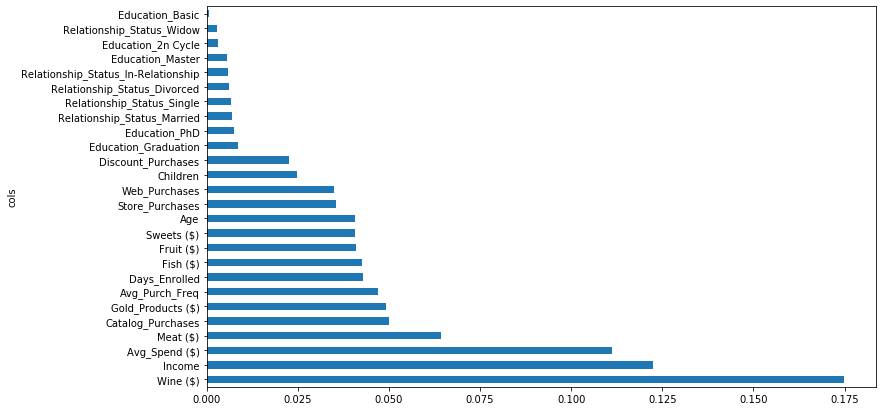


OOB Score:  0.4350199843157163

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}

Testing RMSE: 10.366984795650158

Testing R2:  0.4331103900048644


In [90]:
### Analyzing Performance & Feature Importance Towards Cust Accept % ###

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(best_rfr, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_rfr.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))